## Model comparison notebook

by Xuan Fang in 2025

part of the manuscript "A Bayesian framework for systems model refinement and selection of calcium signaling"

In [4]:
import pickle 
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm
from pymc import Model, Normal, Slice, sample, traceplot
import numpy as np
from matplotlib import rcParams
from scipy.stats import lognorm
import statsmodels.api as sm
import sunode
from sunode.wrappers.as_pytensor import solve_ivp
import pandas as pd
from arviz.stats import stats
import pytensor

In [7]:
def minmax_scaling(ar):
    ar-=ar.min()
    ar/=ar.max()
    return ar

In [5]:
path='/home/xfang2/repos/bayes/data/inference_data/cyto_ER_shuttling'
K=3
# dummy variables
nCells=7
normalize=True
ts=np.linspace(0,1,10)


In [8]:
# model1
y0sVals={'cyto': 1.0,'ER1': 1.0e-1,'ER2': 1.0e-1}
y0s1=[0,0,0]
y0s2=[0,0,0]

def dydt1(t,y,params):
    dcytodt = params.kRyr * y.ER2 - params.kSC * y.cyto
    dER1dt = params.kSC * y.cyto - params.kcomp * y.ER1
    dER2dt = params.kcomp * y.ER1 - params.kRyr * y.ER2

    return {
    'cyto': dcytodt,
    'ER1': dER1dt,
    'ER2': dER2dt}

with pm.Model() as model1:
    # weight
    w=pm.Dirichlet('w', a=np.ones(K))

    # Hyperparams
    mu_kSC = pm.Lognormal('mu_kSC', mu=pm.math.log(3.0), sigma=1e0, shape=K) 
    mu_kRyr = pm.Lognormal('mu_kRyr', mu=pm.math.log(2e-2), sigma=5e-1, shape=K) 
    mu_kcomp = pm.Lognormal('mu_kcomp', mu=pm.math.log(2.0e-1), sigma=5e-1, shape=K)

    sigma_kSC = pm.HalfNormal('sigma_kSC', sigma=1e-1, shape=K)
    sigma_kRyr = pm.HalfNormal('sigma_kRyr', sigma=1e-1, shape=K)
    sigma_kcomp = pm.HalfNormal('sigma_kcomp', sigma=1e-1, shape=K)

    kSC_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_kSC), sigma=sigma_kSC, shape=K)
    kRyr_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_kRyr), sigma=sigma_kRyr, shape=K)
    kcomp_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_kcomp), sigma=sigma_kcomp, shape=K)

    kSC = pm.Mixture('kSC', w=w, comp_dists=kSC_lognormal_dist, shape=nCells)
    kRyr = pm.Mixture('kRyr', w=w, comp_dists=kRyr_lognormal_dist, shape=nCells)
    kcomp = pm.Mixture('kcomp', w=w, comp_dists=kcomp_lognormal_dist, shape=nCells)     

     # initial values
    y0s={'cyto': (np.array(y0s1), (nCells)),
    'ER1': (np.repeat(y0sVals['ER1'], nCells), (nCells)),
    'ER2': (np.array(y0s2), (nCells))}

    # params
    params = {'kSC': (kSC, (nCells)),
        'kRyr': (kRyr, (nCells)),
        'kcomp': (kcomp, (nCells)),
        'useless': (np.array(1.0e0), ()) # bug of sunode: need this to make it work
        }

    # running simulations of proposed param sets
    solution, _, problem, solver, _, _ = solve_ivp(
    y0=y0s,
    params=params,
    rhs=dydt1,
    tvals=ts,
    t0=ts[0],)                
    sim1 = pm.Deterministic('sim1', solution['cyto']) 
    sim2 = pm.Deterministic('sim2', solution['ER2'])

    if normalize:
        # pytensor.map does not specify dimension specification. So we need to do transpose back and forth
        sim1=sim1.T
        sim2=sim2.T
        sim1,_ = pytensor.map(fn=minmax_scaling, sequences=sim1)
        sim2,_ = pytensor.map(fn=minmax_scaling, sequences=sim2)
        sim1=sim1.T
        sim2=sim2.T

trace1=az.from_netcdf(path+'/model1_trace_expt.nc')


In [9]:
# model2
y0sVals={'cyto': 1.0,'ER1': 1.0e-1,'ER2': 1.0e-1}
y0s1=[0,0,0]
y0s2=[0,0,0]

def dydt2(t,y,params):
    dcytodt = params.kRyr * y.ER2 - params.kSC * y.cyto
    dER2dt = params.kSC * y.cyto - params.kRyr * y.ER2

    return {
    'cyto': dcytodt,
    'ER2': dER2dt}

with pm.Model() as model2:
    # weight
    w=pm.Dirichlet('w', a=np.ones(K))

    # Hyperparams
    mu_kSC = pm.Lognormal('mu_kSC', mu=pm.math.log(3.0), sigma=1e0, shape=K) 
    mu_kRyr = pm.Lognormal('mu_kRyr', mu=pm.math.log(2e-2), sigma=5e-1, shape=K) 

    sigma_kSC = pm.HalfNormal('sigma_kSC', sigma=1e-1, shape=K)
    sigma_kRyr = pm.HalfNormal('sigma_kRyr', sigma=1e-1, shape=K)

    kSC_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_kSC), sigma=sigma_kSC, shape=K)
    kRyr_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_kRyr), sigma=sigma_kRyr, shape=K)

    kSC = pm.Mixture('kSC', w=w, comp_dists=kSC_lognormal_dist, shape=nCells)
    kRyr = pm.Mixture('kRyr', w=w, comp_dists=kRyr_lognormal_dist, shape=nCells)  

     # initial values
    y0s={'cyto': (np.array(y0s1), (nCells)),
    'ER2': (np.array(y0s2), (nCells))}

    # params
    params = {'kSC': (kSC, (nCells)),
        'kRyr': (kRyr, (nCells)),
        'useless': (np.array(1.0e0), ()) # bug of sunode: need this to make it work
        }

    # running simulations of proposed param sets
    solution, _, problem, solver, _, _ = solve_ivp(
    y0=y0s,
    params=params,
    rhs=dydt2,
    tvals=ts,
    t0=ts[0],)                
    sim1 = pm.Deterministic('sim1', solution['cyto']) 
    sim2 = pm.Deterministic('sim2', solution['ER2'])

    if normalize:
        # pytensor.map does not specify dimension specification. So we need to do transpose back and forth
        sim1=sim1.T
        sim2=sim2.T
        sim1,_ = pytensor.map(fn=minmax_scaling, sequences=sim1)
        sim2,_ = pytensor.map(fn=minmax_scaling, sequences=sim2)
        sim1=sim1.T
        sim2=sim2.T

trace2=az.from_netcdf(path+'/model2_trace_expt.nc')


In [10]:
# model3
y0sVals={'cyto': 1.0,'ER1': 1.0e-1,'ER2': 1.0e-1}
y0s1=[0,0,0]
y0s2=[0,0,0]

def dydt3(t,y,params):
    dcytodt = params.kRyr * y.ER2 - params.Vmserca/(1+(params.Kdserca/y.cyto)**2)
    dER1dt =  params.Vmserca/(1+(params.Kdserca/y.cyto)**2) - params.kcomp * y.ER1
    dER2dt = params.kcomp * y.ER1 - params.kRyr * y.ER2

    return {
    'cyto': dcytodt,
    'ER1': dER1dt,
    'ER2': dER2dt}

with pm.Model() as model3:
    # weight
    w=pm.Dirichlet('w', a=np.ones(K))

    # Hyperparams
    mu_kRyr = pm.Lognormal('mu_kRyr', mu=pm.math.log(2e-2), sigma=5e-1, shape=K) 
    mu_kcomp = pm.Lognormal('mu_kcomp', mu=pm.math.log(2.0e-1), sigma=5e-1, shape=K)
    mu_Vmserca = pm.Lognormal('mu_Vmserca', mu=pm.math.log(1.5), sigma=5e-1, shape=K) 
    mu_Kdserca = pm.Lognormal('mu_Kdserca', mu=pm.math.log(5.0e-1), sigma=5e-1, shape=K) 

    sigma_kRyr = pm.HalfNormal('sigma_kRyr', sigma=1e-1, shape=K)
    sigma_kcomp = pm.HalfNormal('sigma_kcomp', sigma=1e-1, shape=K)
    sigma_Vmserca = pm.HalfNormal('sigma_Vmserca', sigma=1e-1, shape=K)
    sigma_Kdserca = pm.HalfNormal('sigma_Kdserca', sigma=1e-1, shape=K)

    kRyr_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_kRyr), sigma=sigma_kRyr, shape=K)
    kcomp_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_kcomp), sigma=sigma_kcomp, shape=K)
    Vmserca_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_Vmserca), sigma=sigma_Vmserca, shape=K)
    Kdserca_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_Kdserca), sigma=sigma_Kdserca, shape=K)

    kRyr = pm.Mixture('kRyr', w=w, comp_dists=kRyr_lognormal_dist, shape=nCells)
    kcomp = pm.Mixture('kcomp', w=w, comp_dists=kcomp_lognormal_dist, shape=nCells)     
    Vmserca = pm.Mixture('Vmserca', w=w, comp_dists=Vmserca_lognormal_dist, shape=nCells)
    Kdserca = pm.Mixture('Kdserca', w=w, comp_dists=Kdserca_lognormal_dist, shape=nCells)     

     # initial values
    y0s={'cyto': (np.array(y0s1), (nCells)),
    'ER1': (np.repeat(y0sVals['ER1'], nCells), (nCells)),
    'ER2': (np.array(y0s2), (nCells))}

    # params
    params = {
        'kRyr': (kRyr, (nCells)),
        'kcomp': (kcomp, (nCells)),
        'Vmserca': (Vmserca, (nCells)),
        'Kdserca': (Kdserca, (nCells)),
        'useless': (np.array(1.0e0), ()) # bug of sunode: need this to make it work
        }

    # running simulations of proposed param sets
    solution, _, problem, solver, _, _ = solve_ivp(
    y0=y0s,
    params=params,
    rhs=dydt3,
    tvals=ts,
    t0=ts[0],)                
    sim1 = pm.Deterministic('sim1', solution['cyto']) 
    sim2 = pm.Deterministic('sim2', solution['ER2'])

    if normalize:
        # pytensor.map does not specify dimension specification. So we need to do transpose back and forth
        sim1=sim1.T
        sim2=sim2.T
        sim1,_ = pytensor.map(fn=minmax_scaling, sequences=sim1)
        sim2,_ = pytensor.map(fn=minmax_scaling, sequences=sim2)
        sim1=sim1.T
        sim2=sim2.T

trace3=az.from_netcdf(path+'/model3_trace_expt.nc')


In [11]:
valName={'WAIC':'elpd_waic','loo':'elpd_loo'}
ic='loo'

/home/xfang2/anaconda3/envs/sunode-env/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/xfang2/anaconda3/envs/sunode-env/lib/python3.10/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


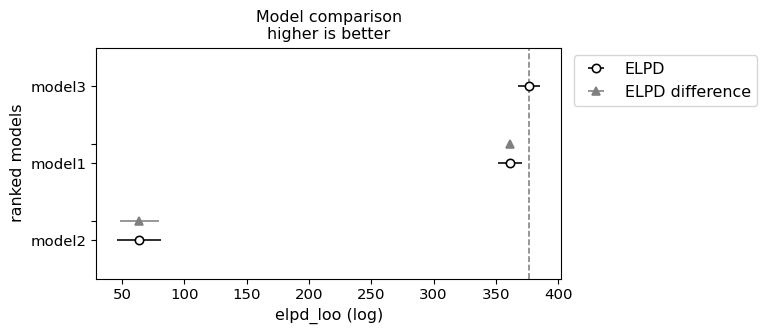

In [12]:
# WAIC
nModels=3
idata1=stats.convert_to_inference_data(trace1,model=model1)
idata2=stats.convert_to_inference_data(trace2,model=model2)
idata3=stats.convert_to_inference_data(trace3,model=model3)
traceDict={'model1': idata1, 'model2': idata2, 'model3': idata3}
dfwaic = pm.compare(traceDict, ic=ic, var_name='Y1')

az.plot_compare(dfwaic, insample_dev=False)

elpds_waic_y1=[]
for i in range(nModels):
    name=valName[ic]
    val=dfwaic[name]['model{}'.format(i+1)]
    elpds_waic_y1.append(val)

/home/xfang2/anaconda3/envs/sunode-env/lib/python3.10/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


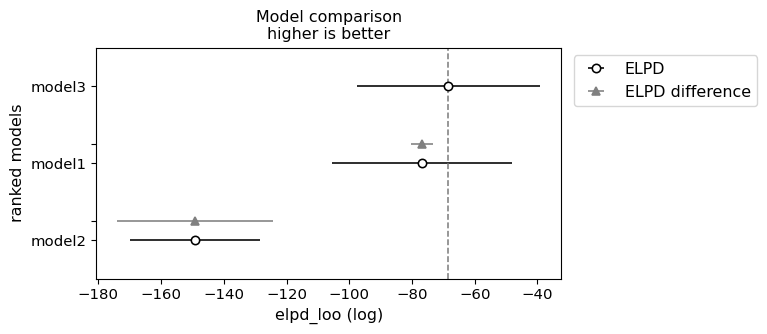

In [13]:
# WAIC
nModels=3
idata1=stats.convert_to_inference_data(trace1,model=model1)
idata2=stats.convert_to_inference_data(trace2,model=model2)
idata3=stats.convert_to_inference_data(trace3,model=model3)
traceDict={'model1': idata1, 'model2': idata2, 'model3': idata3}
dfwaic = pm.compare(traceDict, ic=ic, var_name='Y2')

az.plot_compare(dfwaic, insample_dev=False)

elpds_waic_y2=[]
for i in range(nModels):
    name=valName[ic]
    val=dfwaic[name]['model{}'.format(i+1)]
    elpds_waic_y2.append(val)

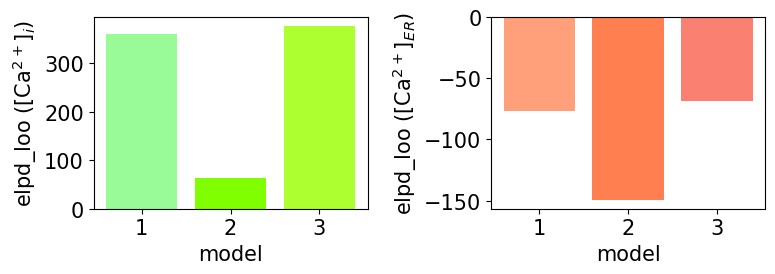

In [14]:
rcParams['figure.figsize']=8,3
rcParams['font.size']=15

fig=plt.figure()
ax1=fig.add_subplot(121)
ax1.set_xlabel('model')
ax1.set_ylabel('elpd_{} ([Ca$^2$$^+$]$_i$)'.format(ic))
xs=np.arange(1,nModels+1)
ax1.bar(xs,elpds_waic_y1,color=['palegreen','chartreuse','greenyellow'])
    
ax1=fig.add_subplot(122)
ax1.set_xlabel('model')
ax1.set_ylabel('elpd_{} ([Ca$^2$$^+$]$_E$$_R$)'.format(ic))
xs=np.arange(1,nModels+1)
ax1.bar(xs,elpds_waic_y2,color=['lightsalmon','coral','salmon'])
    
plt.tight_layout()
plt.gcf().savefig('model_comparison_expt.png')